In [ ]:
# 정의
CIFAR-10 Dataset과 유사한 Dataset라고 정의하고 CIFAR-10 Dataset에 대한 Image Classification SOTA를 찾아보고 구현하여 해결하려 했습니다.
하지만, 참여 시작 가능했던 시간이 오후 2시 이후였기에 시간이 부족하여 SOTA를 활용한 최고의 결과보단 최선의 결과를 내보자 생각하고 진행했습니다.

# 문제 해결 위해 만든 모델에 대한 설명과 그 모델을 선택한 이유
문제는 한정된 GPU 자원과 구현 시간때문에 제한시간 안에 한 모델에 대한 3번 이상의 Test를 진행하기 어려워 보인다는 점이 존재했습니다.
이 문제때문에, 비교적 쉽게 사용가능하고 CIFAR-10 Dataset에서 높은 정확도를 보여주는 EfficientNet 모델들을 사용하기로 결정하고 진행했습니다.


EfficientNet 모델 Test는 B0, B4, B7 세 가지 모델을 진행해보았고 B0은 100, 200, 300 Epoch, B4와 B7은 3,7,10 Epoch로 학습 진행하였고 나머지 하이퍼파라미터는 동일하게 진행하였습니다.
최종적으론, B7-4Epoch이 제일 좋은 결과를 보여주었지만 제한 시간 안에 성과를 거두기 힘들어 B4-10Epoch를 선택하였습니다.

In [ ]:
# PyTorch용 EffcientNet 패키지 설치
!pip install efficientnet_pytorch

In [5]:
# 사전학습된 EfficientNet-B4 불러오기
from efficientnet_pytorch import EfficientNet

MODEL_NAME = 'efficientnet-b4'
BATCH_SIZE = 5
IMAGE_GRID_SIZE = 7
FINGER_TYPES = {'0': 'dog', '1': 'elephant', '2': 'giraffe', '3': 'guitar', '4': 'horse', '5': 'house', '6': 'person'}

image_size = EfficientNet.get_image_size(MODEL_NAME)
model = EfficientNet.from_pretrained(MODEL_NAME, num_classes=len(FINGER_TYPES.keys())) # 지문은 LWRTA 순으로 5개의 레이블을 가짐

print(f'Input size of model: {image_size}')

Loaded pretrained weights for efficientnet-b4
Input size of model: 380


In [2]:
# EfficientNet-B0에서 CNN 레이어 freeze
# for n, p in model.named_parameters():
#     if '_fc' not in n:
#         p.requires_grad = False
# print('CNN layers are frozoen!')

In [6]:
# 데이터셋 불러오기
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split

dataset_path = r'train'
testset_path = r'test'
compose_options = transforms.Compose([transforms.Resize((image_size, image_size)),
                                      transforms.ToTensor()])



# Train/Valid 데이터셋 불러오기
dataset = datasets.ImageFolder(os.path.join(dataset_path), compose_options)
test_dataset = datasets.ImageFolder(os.path.join(testset_path), compose_options)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size,test_size])

# DataLoader 만들기
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
batch_num['train'] = len(dataloaders['train'])
batch_num['valid'] = len(dataloaders['valid'])

print(f'Mini batch size: {BATCH_SIZE}')
print(f'Train batch size: {batch_num["train"]}')
print(f'Valid batch size: {batch_num["valid"]}')

Mini batch size: 5
Train batch size: 272
Valid batch size: 68


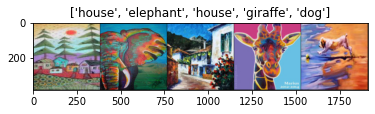

Train dataset


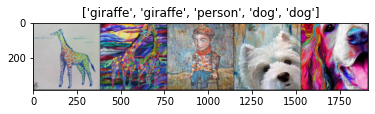

Valid dataset


In [7]:
# 데이터셋 보여주기
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

    
# Train 보여주기
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:IMAGE_GRID_SIZE])
imshow(out, title=[FINGER_TYPES[str(int(x))] for x in classes[:IMAGE_GRID_SIZE]])
print('Train dataset')

# Valid 보여주기
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:IMAGE_GRID_SIZE]) 
imshow(out, title=[FINGER_TYPES[str(int(x))] for x in classes[:IMAGE_GRID_SIZE]])
print('Valid dataset')



In [23]:
# 모델 학습 함수 선언
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    a, preds = torch.max(outputs, 1)
#                     print('===')
#                     print(a)
#                     print('===')
#                     print(preds)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [9]:
# 학습에 필요한 설정 준비
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms

torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
                      
print(f'Is cuda available? {"YES!" if torch.cuda.is_available() else "No!"}')

Is cuda available? YES!


In [24]:
# 학습시작
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lambda epoch: 0.98739)

model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
#  CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)` 오류 시 재부팅 필요

Epoch 0/9
----------
===
tensor([1.8936, 2.7224, 3.9462, 2.5731, 1.6603], device='cuda:0',
       grad_fn=<MaxBackward0>)
===
tensor([1, 2, 0, 1, 4], device='cuda:0')
===
tensor([1.5467, 2.9426, 3.8731, 4.4837, 1.1267], device='cuda:0',
       grad_fn=<MaxBackward0>)
===
tensor([5, 3, 6, 0, 6], device='cuda:0')
===
tensor([3.1081, 4.5162, 2.6205, 3.9662, 3.6533], device='cuda:0',
       grad_fn=<MaxBackward0>)
===
tensor([1, 6, 5, 0, 4], device='cuda:0')
===
tensor([2.5847, 4.2576, 2.8469, 4.1084, 1.6219], device='cuda:0',
       grad_fn=<MaxBackward0>)
===
tensor([6, 6, 1, 0, 3], device='cuda:0')
===
tensor([3.4258, 2.8782, 3.6140, 3.0416, 3.3670], device='cuda:0',
       grad_fn=<MaxBackward0>)
===
tensor([6, 3, 0, 0, 6], device='cuda:0')
===
tensor([4.2188, 1.9757, 4.2542, 4.4073, 1.3928], device='cuda:0',
       grad_fn=<MaxBackward0>)
===
tensor([0, 2, 2, 6, 1], device='cuda:0')
===
tensor([5.3637, 1.7127, 5.9626, 1.2286, 4.0314], device='cuda:0',
       grad_fn=<MaxBackward0>)
==

KeyboardInterrupt: 

In [ ]:
# print(model.extract_features)
# with torch.no_grad():
#     for inputs, labels in dataloaders['valid']:
#         inputs = inputs.to(device)
#         o = model.extract_features(inputs)

with torch.no_grad():
    img = valid_dataset[0][0].unsqueeze(0).to(device)
    o = model.extract_features(img).squeeze(0)
    print(o.flatten().shape)

In [ ]:
test_dataset

In [7]:
# valid__dataset, test_dataset을 사용가능한형태로 변형
usable_valid_dataset = [o[0].unsqueeze(0) for o in valid_dataset]
usable_test_dataset = [o[0].unsqueeze(0) for o in test_dataset]
usable_valid_dataset = torch.vstack(usable_valid_dataset)
usable_test_dataset = torch.vstack(usable_test_dataset)
print(usable_valid_dataset.shape) # NCWH로 변환
print(usable_test_dataset.shape) # NCWH로 변환

torch.Size([340, 3, 380, 380])
torch.Size([350, 3, 380, 380])


In [ ]:
# Predict 하기
def predict(inputs):
    if len(inputs.shape) != 4:
        inputs = inputs.unsqueeze(0)
    inputs = inputs.to(device)
    with torch.no_grad():
        return torch.max(model(inputs), 1)[1]
    
results = predict(usable_test_dataset)
print(results)

In [ ]:
def to_csv(filename, results):
    with open(filename, 'w') as f:
        f.write(',answer value\n')
        for i, r in enumerate(results):
            f.write(f'{i},{r}\n')
            
to_csv('answer_b4.csv', results)